### Import required libraries

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preparation

In [112]:
df = pd.read_csv("train.csv")

target = "label"

# rename the column whose value is to be predicted to "label"
df = df.rename(columns={"left": target}) 

# make target the last column of dataframe
cols = df.columns.tolist()
cols.remove(target)
df = df[cols + [target]] 

### Determine feature types 

In [113]:
# TODO: doubt
# How to decide which feature not to take as categorical data
# eg should "average_montly_hours" be categorical
# what about number_project ?
# one way could be to look at number of distinct values of a feature using df.info()

continuous_feat = ["satisfaction_level", "last_evaluation", "average_montly_hours"]
idk_feat = ["number_project", "time_spend_company",]
categorical_feat = ["Work_accident", "promotion_last_5years", "sales", "salary"]
target_feat = [target]

In [114]:
TYPE_CATEGORICAL = "categorical"
TYPE_CONTINUOUS = "continuous"

# TODO: make better, allow passing feature types
def determine_type_of_feature(df):
    """Determines type of a feature.
    Returns a list of types indexed by feature columns."""
    feature_types = []

    for col in df.columns:
        if col in categorical_feat:
            feature_types.append(TYPE_CATEGORICAL)
        else:
            feature_types.append(TYPE_CONTINUOUS)

    return feature_types

## Helper functions

In [115]:
def is_pure(data):
    """Returns tree if data belongs to only one class label"""
    labels = data[:, -1]
    unique_labels = np.unique(labels)
                
    return len(unique_labels) == 1

### Impurity Measures
 - Gini Index
 - Entropy
 - Misclassification rate

#### Entropy

In [116]:
def entropy(data):
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    prob = counts / counts.sum()
    entropy = sum(prob * - np.log2(prob))

    return entropy


def calculate_overall_entropy(data_below, data_above):
    n_data_points = len(data_below) + len(data_above)
    
    p_data_below = len(data_below) / n_data_points
    p_data_above = len(data_above) / n_data_points

    overall_entropy = (p_data_below * entropy(data_below) 
                      + p_data_above * entropy(data_above))
    
    return overall_entropy

#### Misclassification

In [117]:
def calculate_overall_misclassification(data_below, data_above):
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_misclassification =  (p_data_below * misclassification(data_below) 
                      + p_data_above * misclassification(data_above))
    
    return overall_misclassification


def misclassification(data):
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    impurity = 0

    for num in counts:
        qi = num/float(counts.sum())
        if qi > impurity:
            impurity = qi
    
    return 1 - impurity

#### Gini Index

In [118]:
def gini(data):
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)
    
    impurity = 1
    for lbl_count in counts:
        prob_of_lbl = lbl_count / len(data)
        impurity -= prob_of_lbl**2
    return impurity

def info_gain(left, right, current_uncertainty):
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [119]:
def get_possible_splits(data):
    """Finds all split points for continuous data by taking mean of every 2 successive values,
    For categorical features gets all distinct values"""
    potential_splits = {}
    _, num_columns = data.shape
    
    for col_idx in range(num_columns - 1): # for every column except the target(label) column
        values = data[:, col_idx]
        unique_values = np.unique(values)

        type_of_feature = FEATURE_TYPES[col_idx]
        if  type_of_feature == TYPE_CONTINUOUS:
            #unique_values.sort()   # no need to sort as np.unique() returns sorted values
            potential_splits[col_idx] = []
            
            for index in range(len(unique_values)):
                if index != 0:
                    current_value = unique_values[index]
                    previous_value = unique_values[index - 1]
                    potential_split = (current_value+previous_value) / 2

                    potential_splits[col_idx].append(potential_split)
        else:
            # it's a categorical feature 
            potential_splits[col_idx] = unique_values
            
    return potential_splits


def find_best_split_using_gini(data, potential_splits):
    """Find the best question to ask by iterating over every feature and value."""
    best_gain = 0  # keep track of the best information gain
    best_split_column = best_split_value = None
    
    current_uncertainty = gini(data)

    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            gain = info_gain(data_below, data_above, current_uncertainty)

            if gain >= best_gain:
                best_gain, best_split_column, best_split_value = gain, column_index, value

    return best_split_column, best_split_value, best_gain


def find_best_split_using_entropy(data, potential_splits):
    overall_entropy = 2 # initialize with some very large value. entropy=[0,1]
    best_split_column = best_split_value = None

    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)

            # Skip this split if it doesn't divide the dataset.
            if len(data_below) == 0 or len(data_above)==0:
                continue
            
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)
            if  current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
        
    return best_split_column, best_split_value, overall_entropy
    
    
def find_best_split_using_misclassification(data, potential_splits):
    overall_misclassification = 2  # initialize with some very large value. misclassification=[0,1]
    best_split_column = None
    best_split_value = None
    
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            
            # Skip this split if it doesn't divide the dataset.
            if len(data_below) == 0 or len(data_above)==0:
                continue
                
            current_overall_misclassification = calculate_overall_misclassification(data_below, data_above)
      
            if  current_overall_misclassification <= overall_misclassification:
                overall_misclassification = current_overall_misclassification
                best_split_column = column_index
                best_split_value = value
        
    return best_split_column, best_split_value, overall_misclassification
    
    
def find_best_split(data, potential_splits, split_measure):
    if split_measure == "misclassification":
        return find_best_split_using_misclassification(data, potential_splits)
    elif split_measure == "gini":
        return find_best_split_using_gini(data, potential_splits)
    else:
        return find_best_split_using_entropy(data, potential_splits)
    

def split_data(data, split_column, split_value):
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if  type_of_feature == TYPE_CONTINUOUS:
        yes_data = data[split_column_values <= split_value]
        no_data = data[split_column_values > split_value]
    else:
        yes_data = data[split_column_values == split_value]
        no_data = data[split_column_values != split_value]
        
    return yes_data, no_data

In [120]:
def classify_example(example, tree):
    """Determines examples class label"""
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split()

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    # base case
    if not isinstance(answer,dict):
        return answer

    # recursive part
    else:
        return classify_example(example, answer) 

In [121]:
def classify_data(data):
    """Returns the most prominent label in data"""
    labels = data[:, -1]
    unique_labels, counts = np.unique(labels, return_counts=True)

    index = counts.argmax() # get index of most prominent label
    most_prominent_label = unique_labels[index]

    return most_prominent_label

In [122]:
import random

def train_test_split(df, test_size, random_state = None):
    """Splits data into training and testing sets.
    test_size must be fractional eg 0.2 for 20% split"""

    if random_state is not None:
        # Seed to generate same pseudo-random numbers everytime to make it reproducible.
        random.seed(random_state) 
        
    test_size = round(test_size * len(df)) # change proportion to actual number of rows 

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df, test_df

In [123]:
# Decision Tree Algorithm
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5, impurity_measure_algo="entropy"):
    # data prep
    if counter == 0:
        global column_headers, FEATURE_TYPES
        column_headers = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df
    
    # base case
    if is_pure(data) or (len(data) < min_samples) or (counter == max_depth):
        return classify_data(data)
    
    # recursive part
    else:
        counter += 1
        
        potential_splits = get_possible_splits(data)
        split_column, split_value, impurity = find_best_split(data, potential_splits, impurity_measure_algo)

        # FIXME: test this
        if (impurity == 0) or (split_column is None):
            return classify_data(data)
        
        yes_data, no_data = split_data(data, split_column, split_value)
        

        # instantiate sub-tree
        feature_name = column_headers[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if  type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
        else:
            question = "{} == {}".format(feature_name, split_value)
            
        sub_tree = {question: []}
        
        # find answers (recurse)
        no_answer = decision_tree_algorithm(no_data, counter, min_samples, max_depth, impurity_measure_algo)
        yes_answer = decision_tree_algorithm(yes_data, counter, min_samples, max_depth, impurity_measure_algo)
        
        sub_tree[question].append(yes_answer)
        sub_tree[question].append(no_answer)
        
        return sub_tree

In [124]:
def precision(df):
    # precision = TP / (TP+FP)
    # TP = number_of_people_correctly_identified_as_leaving_the_company
    # FP = number_of_people_INcorrectly_identified_as_leaving_the_company but are actually not leaving
    true_positive = len(df[(df.label == 1) & (df.classification == df.label)])
    false_positive = len(df[(df.classification == 1) & (df.label == 0)])
    
    if true_positive + false_positive == 0:
        return 0
    
    return true_positive / (true_positive+false_positive)


def recall(df):
    # recall = TP/(TP+FN)
    # TP = number_of_people_correctly_identified_as_leaving_the_company
    # FN = number_of_people_actually_leaving the company but identified as not leaving
    true_positive = len(df[(df.label == 1) & (df.classification == df.label)])
    false_negative = len(df[(df.label == 1) & (df.classification != df.label)])
    
    if true_positive + false_negative == 0:
        return 0

    return true_positive / (true_positive + false_negative)
    
def f1_score(df, p=None, r=None):
    if p is None:
        p = precision(df)
    if r is None:
        r = recall(df) 
    
    if p + r == 0:
        return 0
    
    return 2 * (p * r) / (p + r)


In [125]:
def predict(df, tree):
    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))

# accuracy
def accuracy(df):
    correct_predictions = df[df.classification == df.label]
    accuracy = len(correct_predictions) / len(df)
    return accuracy

In [126]:
# accuracy
def calculate_accuracy(df, tree):
    df["classification_correct"] = df.classification == df.label
    accuracy = df.classification_correct.mean()
    
    return accuracy

In [127]:
# error
def error(df):    
    # error = 1 - accuracy
    wrong_predictions = df[df.classification != df.label]
    error = len(wrong_predictions) / len(df)
    return error

# Part-1: (30 points)
Train decision tree only on categorical data. 
Report precision, recall, f1 score and accuracy.

In [128]:
categorical_df = df[categorical_feat + target_feat]
categorical_df.head(2)

,Work_accident,promotion_last_5years,sales,salary,label
0,0,0,sales,low,1
1,0,0,sales,low,0


In [129]:
train_df, test_df = train_test_split(categorical_df, test_size=0.2, random_state=1)
tree = decision_tree_algorithm(train_df, max_depth=5, impurity_measure_algo="misclassification")
predict(test_df, tree)

print("precision", precision(test_df))
print("recall", recall(test_df))
print("f1 score", f1_score(test_df))
print("accuracy", accuracy(test_df))


precision 0
recall 0.0
f1 score 0
accuracy 0.7548932384341637


# Part-2: (30 points)
Train the decision tree with categorical and numerical features.   
Report precision, recall, f1 score and accuracy.

In [130]:
df.head(3)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,label
0,0.10,0.90,7,286,4,0,0,sales,low,1
1,0.89,0.93,4,249,3,0,0,sales,low,0
2,0.38,0.50,2,132,3,0,0,accounting,low,1


In [131]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
tree = decision_tree_algorithm(train_df, max_depth=5)
predict(test_df, tree)

print("precision", precision(test_df))
print("recall", recall(test_df))
print("f1 score", f1_score(test_df))
print("accuracy", accuracy(test_df))

precision 0.9690522243713733
recall 0.9092558983666061
f1 score 0.9382022471910113
accuracy 0.9706405693950177


# Part-3 (10 points) 
Contrast the effectiveness of Misclassification rate, Gini, En-
tropy as impurity measures in terms of precision, recall and accuracy.

In [132]:
# using misclassification rate
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
tree = decision_tree_algorithm(train_df, max_depth=5, impurity_measure_algo="misclassification")
predict(test_df, tree)

print("Using Misclassification rate")
print("precision", precision(test_df))
print("recall", recall(test_df))
print("f1 score", f1_score(test_df))
print("accuracy", accuracy(test_df))


# using gini
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
tree = decision_tree_algorithm(train_df, max_depth=5, impurity_measure_algo="gini")
predict(test_df, tree)

print("\nUsing Gini")
print("precision", precision(test_df))
print("recall", recall(test_df))
print("f1 score", f1_score(test_df))
print("accuracy", accuracy(test_df))


# using entropy
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
tree = decision_tree_algorithm(train_df, max_depth=5, impurity_measure_algo="entropy")
predict(test_df, tree)

print("\nUsing entropy")
print("precision", precision(test_df))
print("recall", recall(test_df))
print("f1 score", f1_score(test_df))
print("accuracy", accuracy(test_df))

Using Misclassification rate
precision 0.9776674937965261
recall 0.7150635208711433
f1 score 0.8259958071278826
accuracy 0.9261565836298933

Using Gini
precision 0.9671814671814671
recall 0.9092558983666061
f1 score 0.9373246024321796
accuracy 0.9701957295373665

Using entropy
precision 0.9690522243713733
recall 0.9092558983666061
f1 score 0.9382022471910113
accuracy 0.9706405693950177


# Part-4: (10 points) 
Visualise training data on a 2-dimensional plot taking one feature (attribute) on one axis and other feature on another axis. Take two suitable features to visualise decision tree boundary.

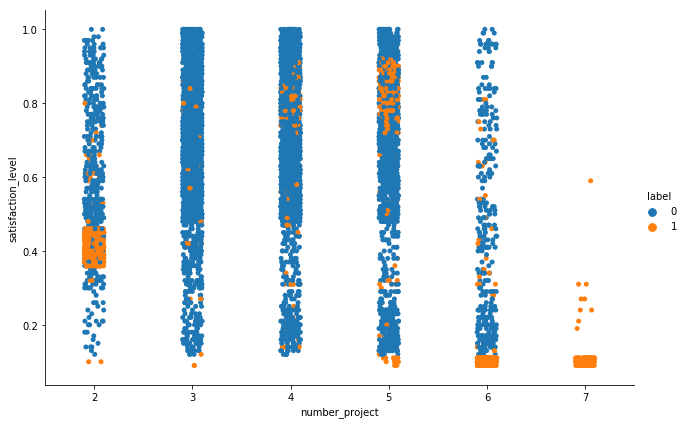

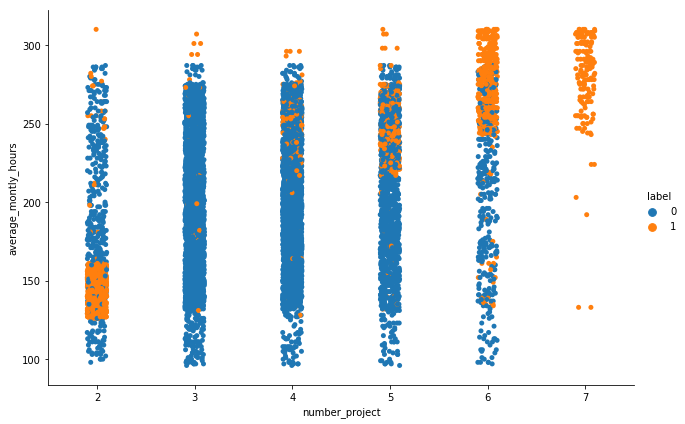

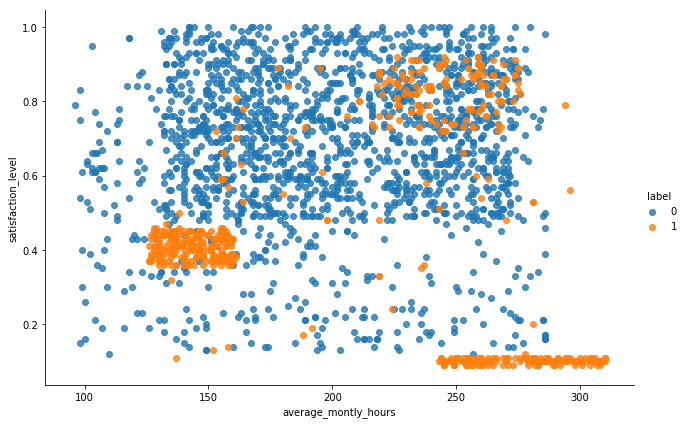

In [133]:
data = train_df.values
train_df.head()
sns.catplot(x="number_project", y="satisfaction_level", hue="label", data=train_df, height=6, aspect=1.5)
sns.catplot(x="number_project", y="average_montly_hours", hue="label", data=train_df, height=6, aspect=1.5)
sns.lmplot(x="average_montly_hours", y="satisfaction_level", hue="label", fit_reg=False, data=test_df, height=6, aspect=1.5)

# Part-5: (10 points) 
1. Plot a graph of training and validation error with respect to depth of your decision tree.
2. Also plot the training and validation error with respect
to number of nodes in the decision tree.

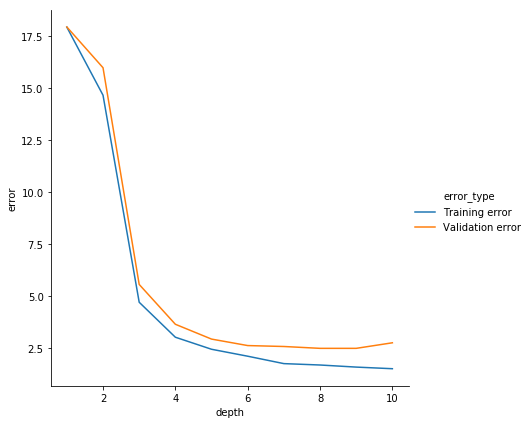

In [134]:
n_sample = 10
data = []

for depth in range(1, n_sample + 1):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
    tree = decision_tree_algorithm(train_df, max_depth=depth, impurity_measure_algo="entropy")
#     print("At depth", depth)

    predict(train_df, tree)
    train_error = error(train_df) * 100
#     print(f"Training error = {train_error:.2f}%")

    predict(test_df, tree)
    validation_error = error(test_df) * 100
#     print(f"Validation error = {validation_error:.2f}%")

    data.append((depth,train_error,"Training error"))
    data.append((depth,validation_error,"Validation error"))

plotdf = pd.DataFrame(data, index=range(len(data)), columns=["depth", "error", "error_type"])
sns.relplot(x="depth", y="error", kind="line", hue="error_type", data=plotdf, height=6)

In [135]:
def tree_size(tree):
    k, v = get_keys_values(tree)
    return k + v

def get_keys_values(d):
    keys, values = 0, 0
    if type(d) == dict:
        for item in d.keys():
            if isinstance(d[item], (list, tuple, dict)):
                keys += 1
                k, v = get_keys_values(d[item])
                values += v
                keys += k
            else:
                keys += 1
                values += 1

    elif type(d) == list or type(d) == tuple:
        for item in d:
            if isinstance(item, (list, tuple, dict)):
                k, v = get_keys_values(item)
                values += v
                keys += k
            else:
                values += 1

    return keys, values

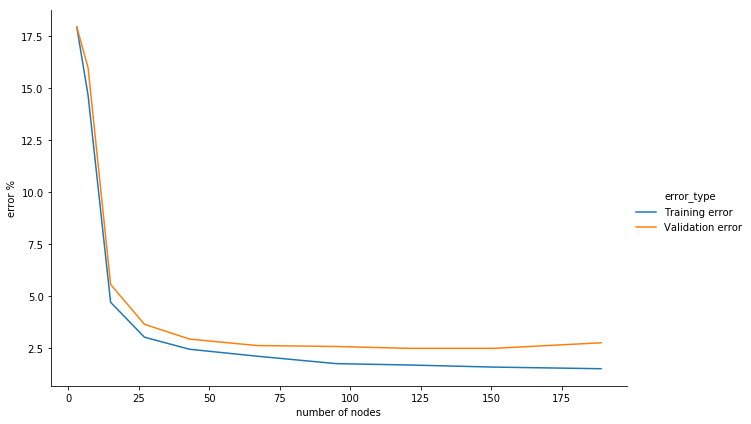

In [136]:
n_sample = 10
data = []

for depth in range(1, n_sample + 1):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
    tree = decision_tree_algorithm(train_df, max_depth=depth, impurity_measure_algo="entropy")
    
    node_count = tree_size(tree)

    predict(train_df, tree)
    train_error = error(train_df) * 100

    predict(test_df, tree)
    validation_error = error(test_df) * 100

    data.append((node_count, train_error, "Training error"))
    data.append((node_count, validation_error, "Validation error"))

plotdf = pd.DataFrame(data, index=range(len(data)), columns=["number of nodes", "error %", "error_type"])
sns.relplot(x="number of nodes", y="error %", kind="line", hue="error_type", data=plotdf, height=6, aspect=1.5)

# Part-6: (10 points) 
Explain how decision tree is suitable handle missing values(few attributes missing in test samples) in data.

When a node is reached whose test sample's data is missing following approaches could be employed :-
 - Predict the class by find the majority class till that node.
 - Randomly choose one subtree and traverse down till we reach a leaf.
 - Traverse down all subtrees (essentially skipping that attribute) and predict using all non missing attribute values. For each possible subtree calculate prediction, keeping the distribution for each sub tree. Finally the class chosen for prediction is the class with the highest density value.